#### CSC 180 Intelligent Systems 

#### William Lorence, Ajaydeep Singh, Romin Akoliya

#### California State University, Sacramento


# Project 1: Yelp Business Rating Prediction using Tensorflow
## Data Preparation
The following block of code sets up the ability to read the Yelp dataset and shows the first 5 rows of both the business dataframe and review dataframe separately. Note that businesses with less than 20 reviews are dropped from the dataframe.

In [299]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import tensorflow as tf
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

path = "./yelp_dataset/"
save_path = "./models/"

df_business = pd.read_json('./yelp_dataset/yelp_academic_dataset_business.json', lines=True, nrows = 1000000)
df_business = df_business[df_business['review_count'] >= 20]

df_business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
12,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28,1,"{'RestaurantsReservations': 'False', 'Restaura...","American (Traditional), Restaurants, Diners, B...","{'Monday': '6:0-22:0', 'Tuesday': '6:0-22:0', ..."
14,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,2575 E Bay Dr,Largo,FL,33771,27.916116,-82.760461,4.5,100,0,"{'OutdoorSeating': 'False', 'RestaurantsGoodFo...","Food, Delis, Italian, Bakeries, Restaurants","{'Monday': '10:0-18:0', 'Tuesday': '10:0-20:0'..."
15,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.953949,-75.143226,4.0,245,1,"{'RestaurantsReservations': 'True', 'Restauran...","Sushi Bars, Restaurants, Japanese","{'Tuesday': '13:30-22:0', 'Wednesday': '13:30-..."


In [300]:
df_review = pd.read_json('./yelp_dataset/yelp_academic_dataset_review.json', lines=True, nrows = 1000000)
df_review.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


The next block of code groups all reviews (text) by business_id and concatenates all the reviews for each business into a single string. This means that for each business, you'll get one entry where all its reviews are combined into one text entry.

df_ready_to_be_sent_to_sklearn converts the df_review_agg series into a dataframe.


In [301]:
df_review_agg = df_review.groupby('business_id')['text'].sum()
df_ready_to_be_sent_to_sklearn = pd.DataFrame({'business_id': df_review_agg.index, 'all_reviews': df_review_agg.values})

The below merges df_ready_to_be_sent_to_sklearn (which contains the concatenated reviews for each business) with df_business (which contains other information about each business such as name, category, location, etc).

df_review_business.shape = returns the shape of the resulting DataFrame (df_review_business), which tells you the number of rows and columns.

In [302]:
df_review_business = pd.merge(df_ready_to_be_sent_to_sklearn, df_business, on='business_id')
df_review_business.shape


(11927, 15)

In [303]:
df_review_business.head()

,business_id,all_reviews,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,--ZVrH2X2QXBFdCilbirsw,This place is sadly perm closed. I was hoping ...,Chris's Sandwich Shop,1531 W Wynnewood Rd,Ardmore,PA,19003,39.997299,-75.292207,4.5,32,0,"{'GoodForKids': 'True', 'RestaurantsAttire': '...","American (Traditional), Restaurants, Pizza, Sa...","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'..."
1,--sXnWH9Xm6_NvIjyuA99w,Ich war das erste mal in Philadelphia und ich ...,Philadelphia,,Philadelphia,PA,,39.952584,-75.165222,4.0,29,1,{'GoodForKids': 'True'},"Public Services & Government, Local Flavor",None
2,-02xFuruu85XmDn2xiynJw,Dr. Curtis Dechant has an excellent chair-side...,Family Vision Center,7475 E Tanque Verde Rd,Tucson,AZ,85715,32.251039,-110.833173,4.5,109,1,"{'ByAppointmentOnly': 'True', 'BusinessParking...","Shopping, Ophthalmologists, Optometrists, Doct...","{'Monday': '0:0-0:0', 'Tuesday': '8:30-17:30',..."
3,-06OYKiIzxsdymBMDAKZug,Had catalytic converters replaced on our Subur...,Washoe Metal Fabricating,905 Bergin Way,Sparks,NV,89431,39.525558,-119.739221,4.5,34,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","RV Dealers, Home Services, Shopping, Tires, Au...","{'Monday': '7:30-17:30', 'Tuesday': '7:30-17:3..."
4,-06ngMH_Ejkm_6HQBYxB7g,I have an old main line that really should be ...,Stewart's De Rooting & Plumbing,415 E Montecito St,Santa Barbara,CA,93101,34.419838,-119.688029,4.0,25,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Plumbing, Home Services","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W..."


## TF-IDF to extract features from reviews

The following block of code takes common words from the filtered dataframe and compiles them into the list "X".

In [304]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer(max_df=0.95, min_df=5, max_features=5000, stop_words='english')

# Fit and transform the 'all_reviews' column
tfidf_matrix = vectorizer.fit_transform(df_review_business['all_reviews'])

# Check the shape of the resulting TF-IDF matrix
# This should be (n_samples, n_features), where n_samples is the number of businesses
# and n_features is the number of words (features) in the TF-IDF representation.
print("Shape of TF-IDF matrix:", tfidf_matrix.shape)

# Get the feature names (words) for printing
feature_names = vectorizer.get_feature_names_out()
#print("Some feature names (words):", feature_names)

Shape of TF-IDF matrix: (11927, 5000)


The next block of code simply takes the words gathered from the reviews (in the form of the TF-IDF matrix) and the review ratings (in stars) and prepares them for training.

In [306]:
X = tfidf_matrix   #Review words
y = df_review_business['stars'].values  # Business star ratings (target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Building and Training
The following function further prepares for training by preparing the neural network model. By default, it uses relu as the activation model and adam as the optimizer. The function allows us to easily tweak values that will affect the overall outcome of the model.

In [307]:
def build_model(activation='relu', optimizer='adam', layer_count=2, neuron_count_array=[128,64]):
    
    if len(neuron_count_array) != layer_count:
        raise Exception("layer_count is not equal to the number of elements in neuron_count_array")
    
    model = Sequential()
    model.add(Dense(neuron_count_array[0], activation=activation, input_shape=(X_train.shape[1],))) # Initial layer, with input shape
    for i in range(layer_count-1):
        model.add(Dense(neuron_count_array[i+1], activation=activation))    #In between layers
    model.add(Dense(1))  # Regression task, so no activation in the output layer
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

When the following code is run, it performs the actual "training" of the model. It creates the model based on the values specified and fits the model over 100 epochs or until the early stopping takes place.

In [363]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')

model = build_model(activation='tanh', optimizer='adam', layer_count=2, neuron_count_array=[256,16])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, callbacks=[early_stopping])

y_pred = model.predict(X_test).flatten()  # Flatten y_pred to make it compatible with y_test
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

c:\Users\legow\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.8365 - val_loss: 0.2338
Epoch 2/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1827 - val_loss: 0.1708
Epoch 3/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1058 - val_loss: 0.1744
Epoch 4/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0817 - val_loss: 0.1806
Epoch 5/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0706 - val_loss: 0.1837
Epoch 6/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0594 - val_loss: 0.1906
Epoch 7/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0524 - val_loss: 0.1994
Epoch 7: early stopping
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Root Mean Squared Error (RMSE): 0.44659811999621063


## Predictions
Finally, the next block of code allows us to test this newly trained model's performance. It takes a random assortment of 5000 businesses (which seems to be the sweet spot for consistency) from the dataset and predicts their rating based on its training. The results are rounded to the nearest 0.5 star due to the fact that the model has no way of knowing that Yelp ratings are restricted to this scale, so any in-between values are treated as how certain the model is about a rating. For example, if the model predicts a 2.89, it is more certain that the correct rating is a 3.0 than a 2.5, so the result will be rounded to 3.0. The first 5 predictions are printed for clarity.

In [364]:
sample_size = 5000

sample_businesses = df_review_business.sample(sample_size).reset_index(drop=True)  # Ensure indices are reset
sample_reviews = vectorizer.transform(sample_businesses['all_reviews']).toarray()
predicted_ratings = model.predict(sample_reviews)

print("\nSample Predictions:")

percent_correct = 100
error_total = 0

for i, row in sample_businesses.iterrows():
    true_rating = row['stars']
    predicted_rating = round(predicted_ratings[i][0] * 2, 0)/2

    error_total += abs(true_rating - predicted_rating)

    if true_rating != predicted_rating:
        percent_correct += (-1 * 100 / sample_size)

    if i<5:
        print(f"Business: {row['business_id']}, True Rating: {true_rating}, Predicted Rating: {predicted_rating}")

percent_correct = round(percent_correct, 4)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step

Sample Predictions:
Business: hJWeckeGVJ9FTzshPG-T5Q, True Rating: 3.0, Predicted Rating: 3.0
Business: -CRjqZ4GxZ6lIa_qMj7-yw, True Rating: 3.5, Predicted Rating: 3.5
Business: JgDCHRGh9b_mFe5V71_u_Q, True Rating: 4.5, Predicted Rating: 4.5
Business: iGTrw3hno7Yf6e6B98VZMA, True Rating: 1.5, Predicted Rating: 1.5
Business: s6rOJDtIABdQ8uLlXSUvgw, True Rating: 4.0, Predicted Rating: 4.0


## Saving the Model

The final block of code saves the current model to the "models" folder in the form of a hdf5 file named "network1". Our other models are also saved here.

In [337]:
import os

model.save(os.path.join(save_path,"network1.hdf5"))

## Which models perform the best?
The best model achieved was network3, which had an RMSE of 0.436. This was the largest model, but there are definitely other optimizations that can be made. We tested numerous iterations of different networks that weren't saved because they performed worse than their counterparts. We only saved the best networks of a given size. Overall, while RELU was fastest to compute and is what we used at the start, tanh and sigmoid were more accurate overall at the cost of efficiency, but also more unpredictable occasionally. Adam was consistently the best optimizer option. Increasing the size of the model also improved results, but with diminishing results due to the simplicity of the data.

In [357]:
model = load_model(os.path.join(save_path,"network1.hdf5"))

y_pred = model.predict(X_test).flatten()  # Flatten y_pred to make it compatible with y_test
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

model = load_model(os.path.join(save_path,"network2.hdf5"))

y_pred = model.predict(X_test).flatten()  # Flatten y_pred to make it compatible with y_test
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

model = load_model(os.path.join(save_path,"network3.hdf5"))

y_pred = model.predict(X_test).flatten()  # Flatten y_pred to make it compatible with y_test
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

model = load_model(os.path.join(save_path,"network4.hdf5"))

y_pred = model.predict(X_test).flatten()  # Flatten y_pred to make it compatible with y_test
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


Root Mean Squared Error (RMSE): 0.4830612096787938
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Root Mean Squared Error (RMSE): 0.4387478617573927
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Root Mean Squared Error (RMSE): 0.4360576611981808
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Root Mean Squared Error (RMSE): 0.42663762595679694


## Data Visualization
Using charts, we can visualize the data by comparing our models' predictions to the actual ratings. The below chart is how well our best model performed. As you can see, it is still prone to large errors, but the overall shape of the predictions overlap the true ratings.

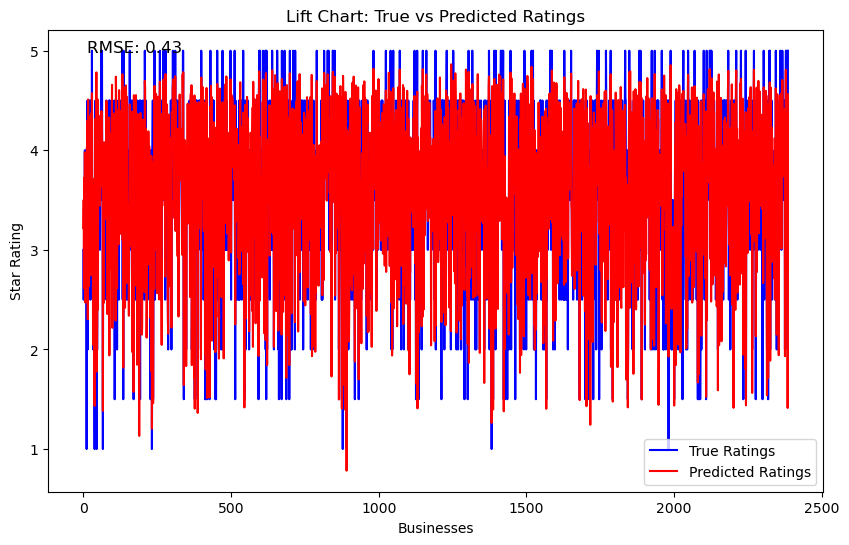

In [358]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test, label="True Ratings", color='blue')
plt.plot(y_pred, label="Predicted Ratings", color='red')
plt.title('Lift Chart: True vs Predicted Ratings')
plt.xlabel('Businesses')
plt.ylabel('Star Rating')
plt.text(x=0.05, y=0.95, s=f'RMSE: {rmse:.2f}', fontsize=12, transform=plt.gca().transAxes)  # Display RMSE
plt.legend()
plt.show()

## Extra Analysis
To further analyze the results, we measured two main statistics: percent correct and average error. Percent correct is simply how many out of the 100 predictions were correct, while the average error represents how many stars on average the model was off by. These stats can be relevant, but are also affected by the amount of overlap between training data and the data used for predictions.

In [365]:
print('Percent correct: ' + str(percent_correct) + "%")

average_error = error_total/sample_size
print('Average error: ' + str(average_error) + " stars")

Percent correct: 71.86%
Average error: 0.1532 stars
